In [1]:
!pip install imblearn
!pip install xgboost
!pip install --user numba shap

In [2]:
!pip install --upgrade scipy
!pip install --upgrade shap

In [3]:
!pip install --upgrade scikit-learn --user

# Projet de Modèle de Scoring

## Introduction
Ce projet vise à développer un modèle de scoring de crédit qui prédit la probabilité qu'un client rembourse son crédit. Ce modèle aidera la société financière à prendre des décisions éclairées sur l'octroi de prêts.


## Importation des Libraries

In [4]:
import sklearn
print(sklearn.__version__)

1.5.0


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, FixedThresholdClassifier, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import mlflow
import mlflow.sklearn

from collections import Counter
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Configuration de MLFlow

In [6]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Définir l'URI de suivi de MLFlow
path_mlruns = '../mlruns/'
mlflow.set_tracking_uri(path_mlruns)

# Affiche le URI de tracking actuel
print(mlflow.get_tracking_uri())

../mlruns/


In [7]:
'''
# Créer une nouvelle expérience et obtenir son ID
experiment_id = mlflow.create_experiment("model_scoring")
print(f"ID de la nouvelle expérience : {experiment_id}")
'''

'\n# Créer une nouvelle expérience et obtenir son ID\nexperiment_id = mlflow.create_experiment("model_scoring")\nprint(f"ID de la nouvelle expérience : {experiment_id}")\n'

## Chargement des Données

In [8]:
path_data_processed = "../data/processed/"
data = pd.read_csv(path_data_processed + 'processed_data_train.csv', index_col=[0])
data_test = pd.read_csv(path_data_processed + 'processed_data_test.csv', index_col=[0])

## Séparation des données en ensembles d'entraînement et de test

In [9]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Définition de la métrique personnalisée

In [10]:
def business_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calculate the business score for predictions.

    Parameters:
    - y_true: array, true labels.
    - y_pred: array, predicted labels.
    - cost_fn: int, cost associated with a false negative.
    - cost_fp: int, cost associated with a false, positive.

    Returns:
    - float, normalized business score between 0 and 1.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = cost_fn * fn + cost_fp * fp
    max_cost = cost_fn * (fn + tp) + cost_fp * (fp + tn)  # worst case scenario: all predictions are wrong
    
    # Normalize and subtract from 1 to flip the scale: higher is better
    return 1 - (total_cost / max_cost)

## Prétraitement des Données
### Vérification des Valeurs Manquantes

In [11]:
print(f"Missing values: {data.isna().sum().sum()} ({data.isna().sum().sum()/data.size:.2%})")

Missing values: 36088183 (19.62%)


In [12]:
# Affichage des colonnes pour vérification
print(data.columns)

# Définition des features numériques et catégorielles
numeric_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

# Affichage des types de features
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       ...
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN',
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN',
       'PREV_PRODUCT_COMBINATION_POS household with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS household without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS other with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN'],
      dtype='object', length=598)
Numeric Features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CH

### Création de pipelines et de transformations

In [13]:
# Définition des transformations pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Entraînement et évaluation du modèle Dummy comme baseline 

In [14]:
# Entraînement et évaluation du modèle Dummy dans un pipeline similaire
mlflow.start_run(run_name="Dummy Classifier", experiment_id=313886723643097310)

dummy_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])

# Cross validation pour Dummy Classifier
cv_results_dummy = cross_val_predict(dummy_pipeline, X_train, y_train, cv=3, method='predict')
cv_proba_dummy = cross_val_predict(dummy_pipeline, X_train, y_train, cv=3, method='predict_proba')[:, 1]

mlflow.sklearn.log_model(dummy_pipeline, "dummy_model")
mlflow.log_metric("Mean AUC", roc_auc_score(y_train, cv_proba_dummy))
mlflow.log_metric("Mean Business Score", business_score(y_train, cv_results_dummy))

mlflow.end_run()

print("Dummy Classifier")
print(f"AUC: {roc_auc_score(y_train, cv_proba_dummy)}")
print(f"Business Score: {business_score(y_train, cv_results_dummy)}")

C:\Users\Farid\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Dummy Classifier
AUC: 0.5
Business Score: 0.5317034396150717


# Entraînement et évaluation de XGBoost

In [15]:
# Démarrage de la session MLFlow
mlflow.start_run(run_name="Optimized XGBoost with class_weight, Fixed Thresholds and Fixed metrics log", experiment_id=313886723643097310)

# Calcul des poids des classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight = class_weights[1] / class_weights[0]

# Définition de la pipeline avec XGBoost et FixedThresholdClassifier
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, scale_pos_weight=weight, random_state=10)
fixed_threshold_classifier = FixedThresholdClassifier(estimator=model_xgb, threshold=0.5, response_method='predict_proba')

model_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', fixed_threshold_classifier)
])

# Paramètres pour GridSearchCV
param_grid = {
    'classifier__estimator__max_depth': [3, 5],
    'classifier__estimator__learning_rate': [0.1, 0.2],
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__subsample': [0.7, 1],
    'classifier__threshold': [0.1, 0.5, 1.0]
}

# Configuration de GridSearchCV avec une métrique personnalisée
business_scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False)
grid_search = GridSearchCV(model_xgb_pipeline, param_grid, scoring=business_scorer, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Récupération et affichage des résultats de validation croisée
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("CV Results: ", cv_results)
print("Meilleurs paramètres : ", best_params)
print("Meilleur score business : ", best_score)

# Calcul des métriques à partir des résultats de la validation croisée
mean_test_auc = np.mean(cv_results['mean_test_score'])
std_test_auc = np.std(cv_results['mean_test_score'])
mlflow.log_metric("Mean AUC", mean_test_auc)
mlflow.log_metric("Std AUC", std_test_auc)
mlflow.log_metric("Optimized Threshold", best_params['classifier__threshold'])
mlflow.log_metric("best_business_score", best_score)

# Enregistrement des paramètres dans MLFlow
mlflow.log_params(best_params)

# Vérification et log des importances des caractéristiques si disponibles
best_model = grid_search.best_estimator_
if hasattr(best_model.named_steps['classifier'].estimator, 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].estimator.feature_importances_
    feature_names = [name for name, _ in model_xgb_pipeline.steps[0][1].transformers_[0]]
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
    print(feature_importance_df.head(20))

mlflow.sklearn.log_model(best_model, "model_v2")
mlflow.end_run()

C:\Users\Farid\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  40.5s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  44.9s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  44.1s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  41.4s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, cla

[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  46.0s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  49.6s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  48.9s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  47.6s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__s

[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  42.5s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  40.7s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  48.3s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  49.1s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__sub

[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  53.7s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  54.8s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time= 1.0min
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.5; total time= 1.1min
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample

## Importance des caractéristiques
Extraction de l'importance des caractéristiques après l'entraînement des modèles :
* **Ajustement du préprocesseur :** J'ai ajusté le preprocessor sur les données d'entraînement, ce qui est essentiel pour préparer les features avant de récupérer leur nom.

* **Gestion des features catégorielles :** J'ai conditionné l'ajustement des caractéristiques catégorielles et la récupération de leurs noms. C'est utile si la liste des caractéristiques catégorielles peut varier ou être vide.

* **Extraction et affichage des importances des caractéristiques :** Après avoir entrainé le modèle, j'ai extrait l'importance de chaque caractéristique et affiché les plus importantes. Cela nous aide à identifier quelles variables ont le plus d'impact sur les prédictions du modèle.

In [17]:
# Ajuster le préprocesseur sur les données d'entraînement
preprocessor.fit(X_train)

# Récupérer les noms des caractéristiques après transformation
feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if name == 'num':
        feature_names += columns
    elif name == 'cat':
        # Ajuster l'encodeur one-hot et obtenir les noms des caractéristiques encodées
        transformer.named_steps['onehot'].fit(X_train[columns])
        feature_names += list(transformer.named_steps['onehot'].get_feature_names_out(columns))

# Entraîner le meilleur modèle avec les paramètres trouvés
best_model = XGBClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

# Récupérer les importances des caractéristiques
feature_importances = best_model.feature_importances_

# Créer un DataFrame avec les importances des caractéristiques
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Afficher les 20 caractéristiques les plus importantes
print(feature_importance_df.head(20))


C:\Users\Farid\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "classifier__estimator__learning_rate", "classifier__estimator__max_depth", "classifier__estimator__n_estimators", "classifier__estimator__subsample", "classifier__threshold" } are not used.

  warnings.warn(smsg, UserWarning)


                                               Feature  Importance
32                                        EXT_SOURCE_3    0.018657
110               NAME_EDUCATION_TYPE_Higher education    0.016999
31                                        EXT_SOURCE_2    0.016341
108                           NAME_INCOME_TYPE_Working    0.009427
1                                          CODE_GENDER    0.009394
0                                   NAME_CONTRACT_TYPE    0.008719
486             PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.007683
281                                 CC_AMT_BALANCE_MIN    0.007020
113  NAME_EDUCATION_TYPE_Secondary / secondary special    0.006856
65                                     FLAG_DOCUMENT_3    0.006674
484            PREV_NAME_CONTRACT_STATUS_Approved_MEAN    0.006597
30                                        EXT_SOURCE_1    0.005790
519  PREV_NAME_GOODS_CATEGORY_Clothing and Accessor...    0.005539
330                       CC_CNT_DRAWINGS_CURRENT_MEAN    0.00

## Outils d'interprétation des modèles
Utilisation de SHAP pour l'interprétation des prédictions du modèle XGBoost :

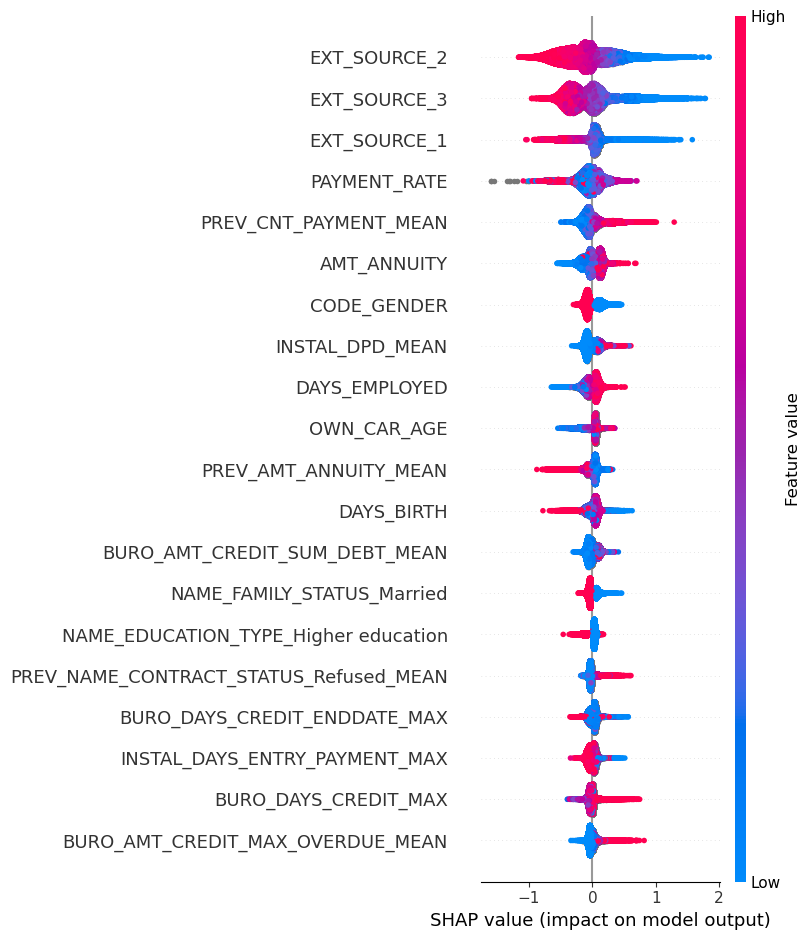

In [18]:
import shap

explainer = shap.TreeExplainer(best_model)

# Calcul des valeurs SHAP (peut prendre du temps selon la taille du jeu de données)
shap_values = explainer.shap_values(X_train)

# Résumé de l'impact des caractéristiques
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

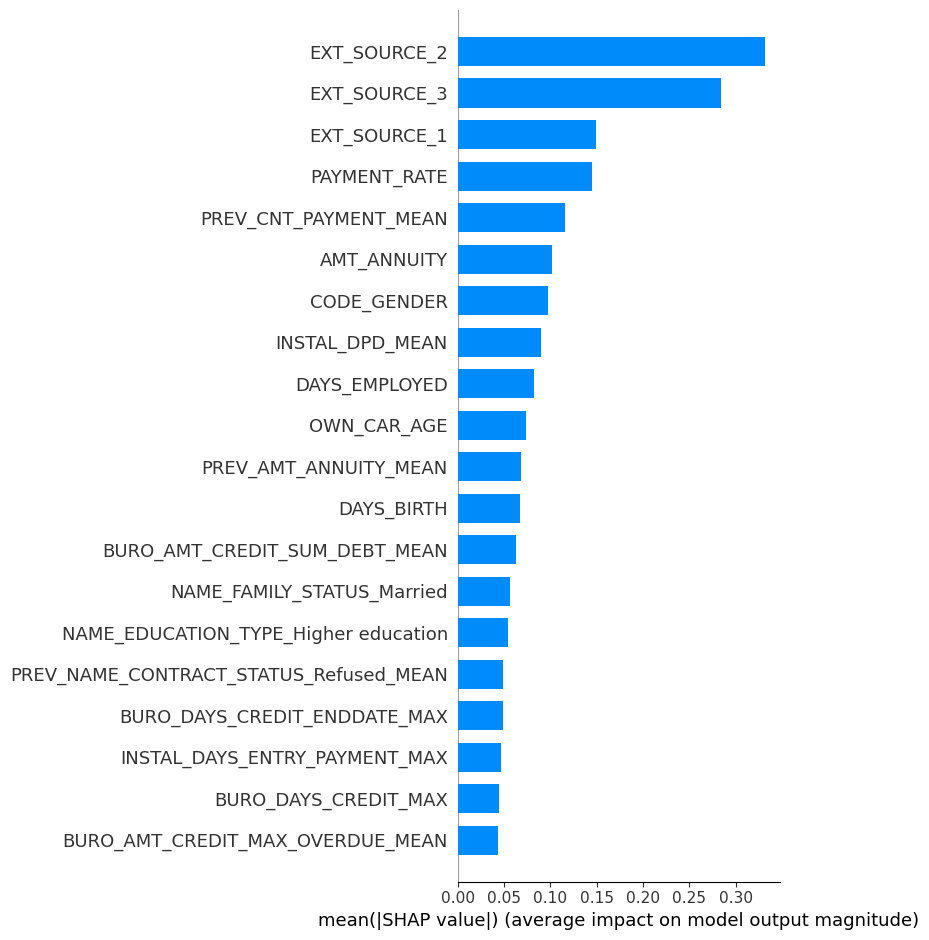

In [19]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")

In [20]:
# impact des caractéristiques pour une seule prédiction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], feature_names=feature_names)

In [21]:
from joblib import dump

# Sauvegarde du meilleur modèle
path_models = '../models/'
dump(best_model, path_models + 'best_model_v2.joblib')

# Pour charger le modèle plus tard
# from joblib import load
# loaded_model = load('best_model.joblib')

['../models/best_model_v2.joblib']

In [24]:
# Sauvegarder le preprocessor
path_preprocessor = '../models/preprocessor.joblib'
dump(preprocessor, path_preprocessor)

['../models/preprocessor.joblib']

In [25]:
# Sauvegarder les noms des caractéristiques
feature_names = X_train.columns.tolist()
with open("../models/feature_names.txt", "w") as f:
    for feature in feature_names:
        f.write(f"{feature}\n")